# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
# 1) Camera calibration using chessboard images

In [1]:
# Importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pickle
%matplotlib inline

In [2]:
# Helper functions
# Show 2 images on the same line for easy comparison
def show2img(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Show 2 images (the second one with gray scale) on the same line for easy comparison
def show2img_gray(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Show 3 images on the same line for easy comparison
def show3img(img1, img2, img3, title1, title2, title3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=50)
    ax3.imshow(img3)
    ax3.set_title(title3, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [4]:
# Make a list of calibration images
images = os.listdir("camera_cal/")

# Step through the list and search for chessboard corners
for fname in images:
    # Read image
    img = cv2.imread('camera_cal/'+fname)
    # Create grayscale image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    if ret == True:
        # If found, add object points, image points
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'output_images/corners_'+fname
        cv2.imwrite(write_name, img)
    else:
        # If not, return the filename
        print("This image can't be processed : "+fname)

This image can't be processed : calibration5.jpg
This image can't be processed : calibration4.jpg
This image can't be processed : calibration1.jpg


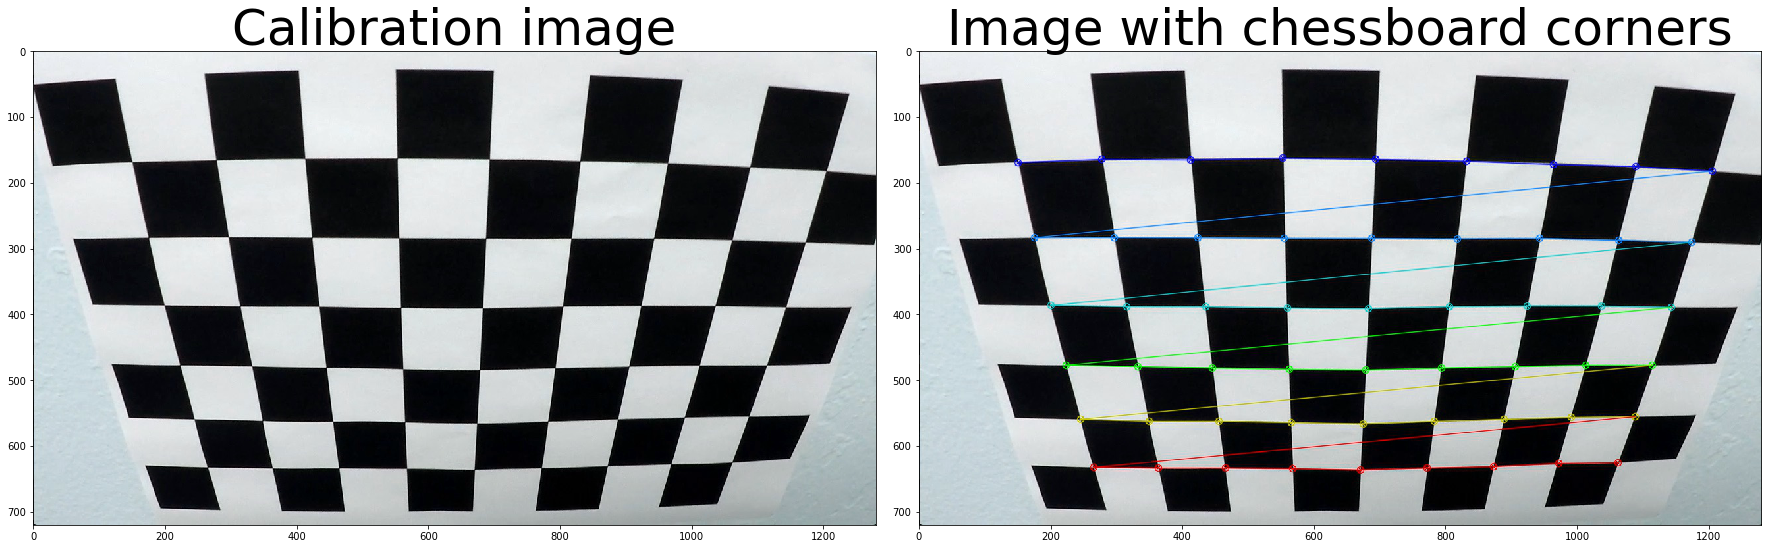

In [5]:
# Show an image (calibration2.jpg) & its chessboard corners
img1 = cv2.imread('camera_cal/calibration2.jpg')
img2 = cv2.imread('output_images/corners_calibration2.jpg')
show2img(img1, img2, 'Calibration image', 'Image with chessboard corners')

In [6]:
# Apply camera calibration to get the matrix (mtx) and distortion coefficients (dist)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Print out the value of mxt & dist
print("Here is the matrix (mtx):")
print(mtx)
print("Here is the distortion coefficients (dist):")
print(dist)

Here is the matrix (mtx):
[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Here is the distortion coefficients (dist):
[[ -2.41017956e-01  -5.30721171e-02  -1.15810354e-03  -1.28318858e-04
    2.67125302e-02]]


In [7]:
# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("calibrated_result.p","wb"))

# 2) Apply a distortion correction to raw images

In [8]:
# Read the matrix (mtx) and coefficients (dist) from calibrated result
# Use the saved data to avoid running the calibration from the beginning when restarting kernel, etc
dist_pickle = pickle.load(open("calibrated_result.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [9]:
# Undistort each chessboard image using the calculated matrix (mtx) & coefficients (dist)
for fname in images:
    # Read image
    img = cv2.imread('camera_cal/'+fname)
    # Create undistorted image & save to file in "output_images" folder
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    write_name = 'output_images/undistorted_'+fname
    cv2.imwrite(write_name, undist)

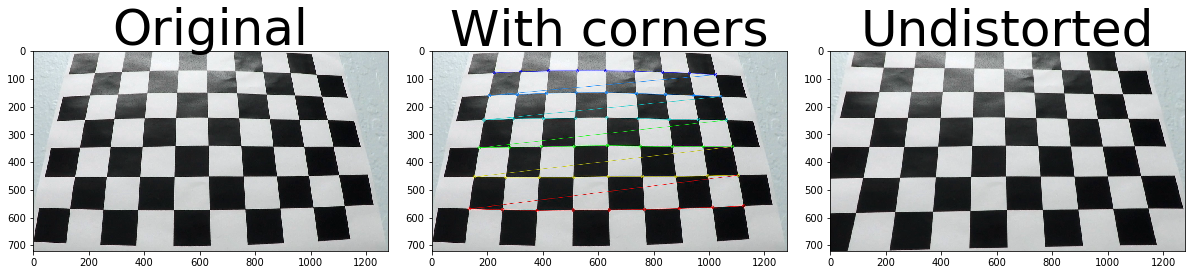

In [10]:
# Show 3 images: original, with chessboard corners, undistorted
img1 = cv2.imread('camera_cal/calibration3.jpg')
img2 = cv2.imread('output_images/corners_calibration3.jpg')
img3 = cv2.imread('output_images/undistorted_calibration3.jpg')
show3img(img1, img2, img3, 'Original', 'With corners', 'Undistorted')

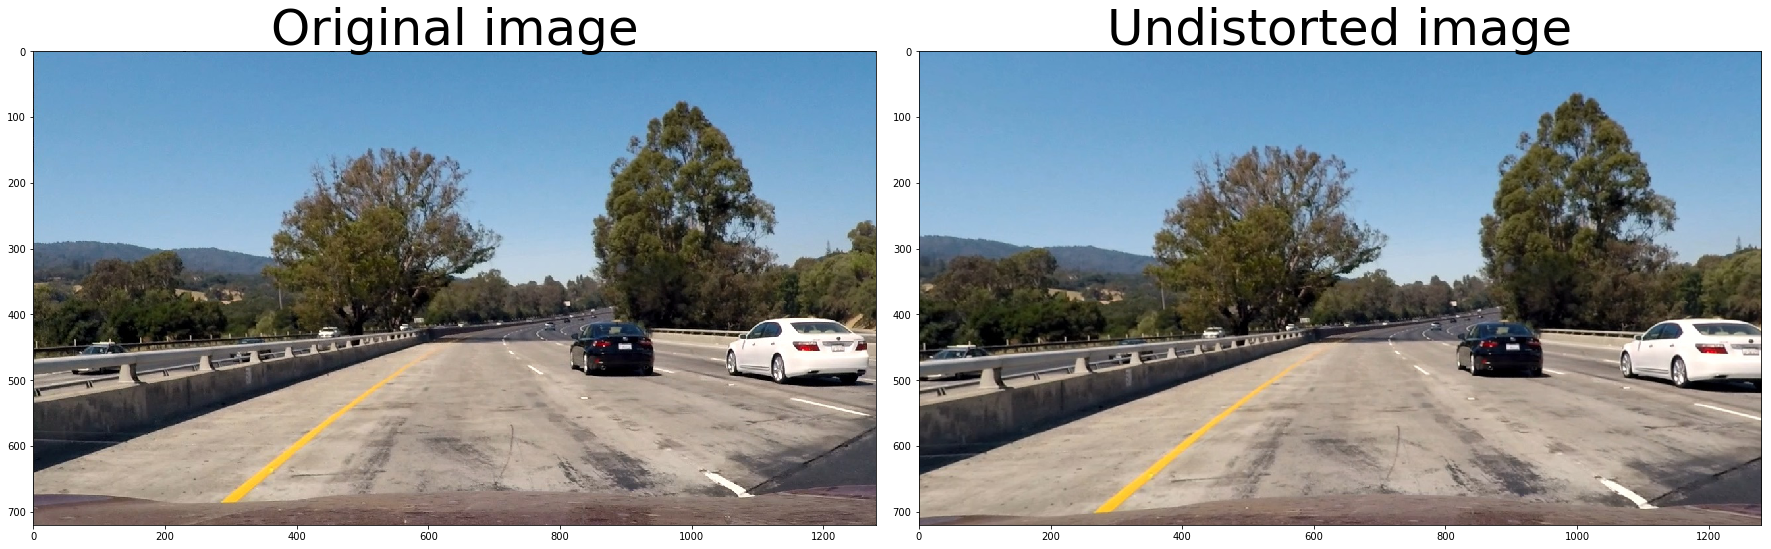

In [11]:
# Generate undistorted image and show with its raw image
raw_original = mpimg.imread('test_images/test1.jpg')
raw_undist = cv2.undistort(raw_original, mtx, dist, None, mtx)
show2img(raw_original, raw_undist, 'Original image', 'Undistorted image')

# 3) Use color transforms, gradients, etc., to create a thresholded binary image.

In [12]:
# A function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold to generate binary image
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1 
    return grad_binary

# A function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

# A function to return the direction of the gradient
# for a given sobel kernel size and threshold values
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

# A function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    hls_binary = np.zeros_like(s_channel)
    hls_binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return hls_binary

# 4) Apply a perspective transform to rectify binary image ("birds-eye view")

# 5) Detect lane pixels and fit to find the lane boundary

# 6) Determine the curvature of the lane and vehicle position with respect to center.

# 7) Warp the detected lane boundaries back onto the original image.

# 8) Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.